# Desarrollo de un modelo de IA para la detección temprana del Parkinson

## Importación de librerías y configuraciones

In [144]:
# Librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocesado y modelado
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

# XGBoost
from xgboost import XGBClassifier

### Construcción del modelo

In [145]:
# Configuraciones
pd.set_option('display.max_columns', None)      # Permitir que se muestren todas las columnas
pd.set_option('display.max_rows', None)         # Permitir que se muestren todas las filas

sns.set(style="whitegrid")                      # Estilo de las gráficas
palette_set2 = sns.color_palette('Set2')        # Paleta de colores Set2

## Carga de datos y exploración inicial

A continuación se describen las características acústicas de los audios recogidas en `audio_features.csv`:

| Variable           | Descripción                                                                                                  |
|--------------------|--------------------------------------------------------------------------------------------------------------|
| `duration_s`       | Duración total del audio en segundos.                                                                        |
| `mean_F0_Hz`       | Frecuencia fundamental media (pitch) en Hertzios, indicador del tono base de la voz.                         |
| `stdev_F0_Hz`      | Desviación estándar de la frecuencia fundamental, mide la variabilidad tonal.                                |
| `jitter_local`     | Variación absoluta local del período fundamental, indicador de inestabilidad en la frecuencia.               |
| `rJitter_rap`      | Jitter relativo promedio absoluto (RAP), variación relativa de frecuencia entre ciclos consecutivos.         |
| `rJitter_ppq5`     | Jitter relativo Pitch Perturbation Quotient a corto plazo (PPQ5).                                            |
| `rJitter_ddp`      | Jitter relativo DDP (derivado de la diferencia de períodos).                                                 |
| `shimmer_local`    | Variación local absoluta de la amplitud entre ciclos consecutivos.                                           |
| `rShimmer_local_dB`| Shimmer relativo medido en decibelios (variación porcentual de amplitud).                                    |
| `APQ3_Shimmer`     | Amplitude Perturbation Quotient calculado en ventanas de 3 ciclos, mide variabilidad de amplitud.            |
| `APQ5_Shimmer`     | Amplitude Perturbation Quotient en ventanas de 5 ciclos.                                                    |
| `sAPQ_Shimmer_dda` | Smoothed Amplitude Perturbation Quotient (dda), versión suavizada del APQ.                                   |
| `mean_HNR_dB`      | Relación armónicos-ruido media en decibelios, indica calidad vocal y nivel de ruido.                         |
| `CPP`              | Cepstral Peak Prominence, prominencia del pico cepstral, relacionada con la claridad del tono.               |
| `mfcc_1-13_mean`   | Media de los 13 coeficientes cepstrales en escala Mel, que representan características espectrales del audio.|
| `mfcc_1-13_std`    | Desviación estándar de los 13 coeficientes cepstrales en escala Mel, reflejando su variabilidad temporal.    |
| `AudioPath`        | Ruta al archivo de audio correspondiente.                                                                    |

In [146]:
# Cargar las características extraídas de los audios del CSV
df_features = pd.read_csv("features_all.csv")

# Mostrar primeras filas
df_features.head()

,duration_s,mean_F0_Hz,stdev_F0_Hz,jitter_local,rJitter_rap,rJitter_ppq5,rJitter_ddp,shimmer_local,rShimmer_local_dB,APQ3_Shimmer,APQ5_Shimmer,sAPQ_Shimmer_dda,mean_HNR_dB,CPP,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,mfcc_6_mean,mfcc_6_std,mfcc_7_mean,mfcc_7_std,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,AudioPath
0,4.483,154.173736,4.043245,0.004321,0.001867,0.002109,0.005600,0.019683,0.177743,0.010844,0.012320,0.032533,23.647861,0.116375,-271.54593,16.958487,141.56535,8.877299,5.776764,7.321685,-22.227964,5.934196,-26.274324,6.774319,11.174428,3.715654,-17.647575,4.811536,4.773445,4.858884,-36.661217,4.227787,5.131048,3.739918,20.554020,3.208958,-3.210110,3.052213,-3.367001,3.663941,./audios_cleaned\HC_A1_0034.wav
1,4.796,229.874112,2.161178,0.002391,0.001359,0.001440,0.004077,0.025744,0.225181,0.012939,0.018917,0.038818,25.920707,0.179618,-298.97880,17.158678,143.34805,6.356058,-52.319374,5.672130,-5.912727,4.073688,-29.489286,5.200922,25.139587,4.314994,14.366303,5.116300,-25.437391,5.880932,15.880417,3.346882,0.496498,3.366862,-8.270984,2.847069,-5.006031,4.127622,-10.713573,3.992330,./audios_cleaned\HC_A1_0036.wav
2,3.537,91.027850,1.179071,0.005275,0.002892,0.003252,0.008677,0.095171,0.835566,0.061813,0.042480,0.185440,14.115027,0.082324,-188.07475,10.398783,136.55916,5.940313,-2.010440,5.347425,23.710331,4.853560,-28.362808,4.456181,26.345608,7.612917,12.657865,5.017746,-12.927169,3.937057,1.793284,5.507174,21.031908,4.974231,10.741927,4.059393,6.752829,4.977106,2.247052,2.861156,./audios_cleaned\HC_A1_0045.wav
3,5.536,122.906335,1.043166,0.003650,0.002129,0.002080,0.006388,0.029811,0.261672,0.016542,0.018472,0.049625,20.529466,0.214122,-195.33672,8.372833,138.25761,6.667186,-64.596565,6.802365,12.194688,3.849799,-34.225850,5.279416,21.446270,3.402569,20.442644,2.155276,-15.545657,3.024096,13.963638,2.256747,19.022612,2.300998,-5.787653,2.350414,-1.466798,2.746421,-16.241877,3.260661,./audios_cleaned\HC_A1_0048.wav
4,4.289,195.631759,2.020129,0.001823,0.000812,0.001017,0.002437,0.030890,0.270554,0.013686,0.022722,0.041058,23.640546,0.357353,-276.95395,19.486975,125.50581,6.753275,-17.654398,5.134702,-17.526237,3.607005,-12.347667,3.394140,11.519006,2.746447,10.960750,3.927329,4.744122,4.982993,-9.977400,4.519415,11.797244,3.407270,-11.325452,3.669723,-1.998906,3.988272,-7.398500,4.933187,./audios_cleaned\HC_A1_0049.wav


## Limpieza básica de datos

In [147]:
# Limpiar nombres de columnas (quitar espacios en blanco al inicio y final)
df_features.columns = df_features.columns.str.strip()

In [148]:
# Dimensiones del datafdrame
print(f"Filas: {df_features.shape[0]}, Columnas: {df_features.shape[1]}")

Filas: 2976, Columnas: 41


In [149]:
# Tipos de datos y valores nulos
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   duration_s         2976 non-null   float64
 1   mean_F0_Hz         2971 non-null   float64
 2   stdev_F0_Hz        2971 non-null   float64
 3   jitter_local       2971 non-null   float64
 4   rJitter_rap        2971 non-null   float64
 5   rJitter_ppq5       2971 non-null   float64
 6   rJitter_ddp        2971 non-null   float64
 7   shimmer_local      2971 non-null   float64
 8   rShimmer_local_dB  2971 non-null   float64
 9   APQ3_Shimmer       2971 non-null   float64
 10  APQ5_Shimmer       2969 non-null   float64
 11  sAPQ_Shimmer_dda   2971 non-null   float64
 12  mean_HNR_dB        2976 non-null   float64
 13  CPP                2976 non-null   float64
 14  mfcc_1_mean        2976 non-null   float64
 15  mfcc_1_std         2976 non-null   float64
 16  mfcc_2_mean        2976 

In [150]:
# Estadísticas básicas de columnas numéricas
df_features.describe()

,duration_s,mean_F0_Hz,stdev_F0_Hz,jitter_local,rJitter_rap,rJitter_ppq5,rJitter_ddp,shimmer_local,rShimmer_local_dB,APQ3_Shimmer,APQ5_Shimmer,sAPQ_Shimmer_dda,mean_HNR_dB,CPP,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,mfcc_6_mean,mfcc_6_std,mfcc_7_mean,mfcc_7_std,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std
count,2976.000000,2971.000000,2971.000000,2971.000000,2971.000000,2971.000000,2971.000000,2971.000000,2971.000000,2971.000000,2969.000000,2971.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,4.508383,162.770336,30.440898,0.017285,0.007680,0.008416,0.023041,0.076290,0.741789,0.032827,0.043329,0.098482,17.360060,0.112483,-265.012654,66.063152,120.792876,27.761436,9.456895,21.213715,27.207574,17.257631,-3.744599,12.159280,-2.438757,11.444492,-4.575035,10.228723,0.641333,9.172493,-5.296094,8.820259,0.788080,8.189444,-3.321515,7.444593,-0.526937,7.181193,-2.739024,6.825472
std,7.039763,43.203267,32.656777,0.011957,0.005698,0.005878,0.017094,0.036392,0.351145,0.017136,0.021957,0.051408,6.191718,0.054606,49.146069,37.834994,30.650341,14.932489,24.506153,12.113651,24.748834,9.359158,17.030140,5.781958,13.567230,5.628151,11.752319,4.948214,9.003795,4.210263,9.864469,4.048563,8.938190,3.769937,7.974934,3.106269,7.644519,2.965860,7.506941,2.874611
min,0.082000,78.105300,0.524004,0.000846,0.000337,0.000472,0.001012,0.003962,0.034992,0.001904,0.002395,0.005713,-5.569851,0.013417,-435.346220,5.087592,-19.862268,3.335675,-88.669310,2.672509,-47.271866,1.850463,-91.620964,1.762998,-64.598400,1.948654,-65.294250,1.744978,-41.304264,1.799159,-49.546290,1.767720,-40.085960,1.028301,-37.724953,1.600269,-36.710426,1.331205,-38.704060,1.163941
25%,2.270000,128.340905,3.209947,0.005125,0.002813,0.002892,0.008440,0.048708,0.441279,0.021867,0.028872,0.065601,13.567941,0.072985,-291.934940,24.181785,105.625407,11.761450,-4.731303,7.729376,14.657281,6.883346,-11.410113,6.417667,-8.591677,5.442551,-11.571245,4.932037,-4.739619,4.906311,-10.112057,4.543655,-3.758052,4.357993,-7.747423,4.267043,-4.495859,4.126690,-6.552016,4.015179
50%,3.321500,157.159728,22.488012,0.018069,0.007415,0.008572,0.022245,0.079023,0.801216,0.030639,0.042357,0.091918,16.025723,0.102794,-260.435485,74.962590,123.131638,30.567916,8.390274,23.466038,25.419965,19.956788,-0.076693,12.781079,-0.708352,12.530327,-4.789466,11.267393,1.347254,9.871261,-4.084565,9.645103,0.875455,8.652839,-2.777001,8.049805,-0.087463,7.750723,-2.211124,7.158116
75%,4.169000,192.140074,43.818421,0.024358,0.010278,0.011531,0.030833,0.098074,0.971899,0.040356,0.054662,0.121069,21.069372,0.141678,-235.311030,95.344959,139.954252,39.452593,23.610132,31.178446,35.990549,24.783667,7.269049,16.646342,5.358926,15.981112,2.234037,13.822905,6.138136,12.418096,1.118365,11.968951,5.377879,11.013772,1.414809,9.753291,3.680085,9.431856,1.993796,8.902222
max,80.248000,508.093401,236.406492,0.087371,0.054212,0.052983,0.162637,0.230160,2.072304,0.146472,0.178522,0.439415,36.818921,0.440157,-37.130530,236.396510,202.457180,70.011360,90.574300,53.915947,121.786430,39.919880,49.123116,31.625305,45.289066,27.594340,43.625183,27.462864,41.656500,23.115694,28.008017,22.132488,38.453533,20.261286,26.125004,16.775682,35.959064,15.545809,22.901588,15.828703


In [151]:
# Eliminación de duplicados
num_duplicados = df_features.duplicated().sum()
print(f"Filas duplicadas: {num_duplicados}")

Filas duplicadas: 0


## Análisis exploratorio de datos (EDA)

In [152]:
# Extraer el grupo de AudioPath
def extract_group(path):
    try:
        # Cambiar \ por / para unificar separadores
        path = path.replace('\\', '/')
        # Quedarse solo con el nombre del archivo
        filename = path.split('/')[-1]
        # Tomar la parte antes del primer guion bajo
        return filename.split('_')[0]
    except Exception:
        return np.nan
    
df_features['Group'] = df_features['AudioPath'].apply(extract_group)

# Aplicar al DataFrame
df_features['Group'] = df_features['AudioPath'].apply(extract_group)

# Comprobar distribución de grupos
print("Distribución de etiquetas en 'Group':")
print(df_features['Group'].value_counts())

# Comprobar si quedan NaN en 'Group'
print("\nNúmero de valores NaN en 'Group':")
print(df_features['Group'].isna().sum())

Distribución de etiquetas en 'Group':
Group
HC    1509
PD    1467
Name: count, dtype: int64

Número de valores NaN en 'Group':
0


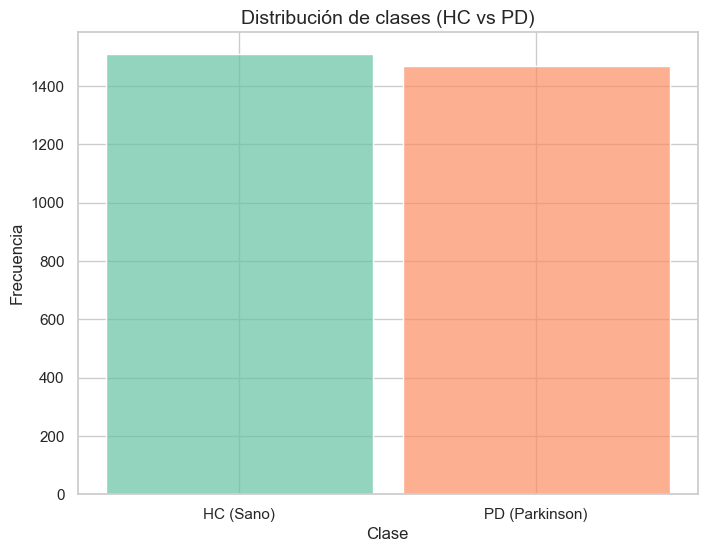

Group
HC    1509
PD    1467
Name: count, dtype: int64


In [153]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_features, x='Group', hue='Group', palette=[palette_set2[0], palette_set2[1]], shrink=0.9, binwidth=0.4, discrete=True, alpha=0.7
)
plt.title('Distribución de clases (HC vs PD)', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend([], [], frameon=False)
plt.xticks(ticks=[0, 1], labels=['HC (Sano)', 'PD (Parkinson)'])
plt.show()

# Mostrar los números exactos
print(df_features['Group'].value_counts())

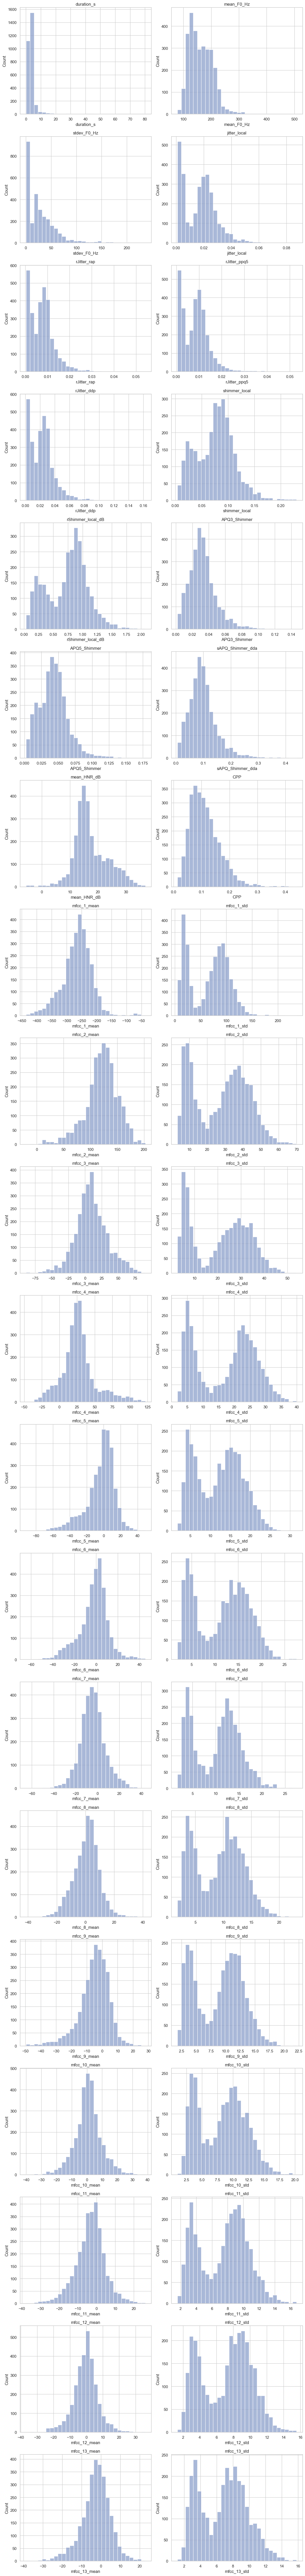

In [154]:
# Columnas numéricas y número de filas necesarias
num_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
n_rows = (len(num_cols) + 1) // 2

plt.figure(figsize=(12, 5 * n_rows))

# Graficar histogramas 2 por fila
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df_features[col].dropna(), bins=30, color=palette_set2[2])
    plt.title(col)

plt.tight_layout()
plt.show()

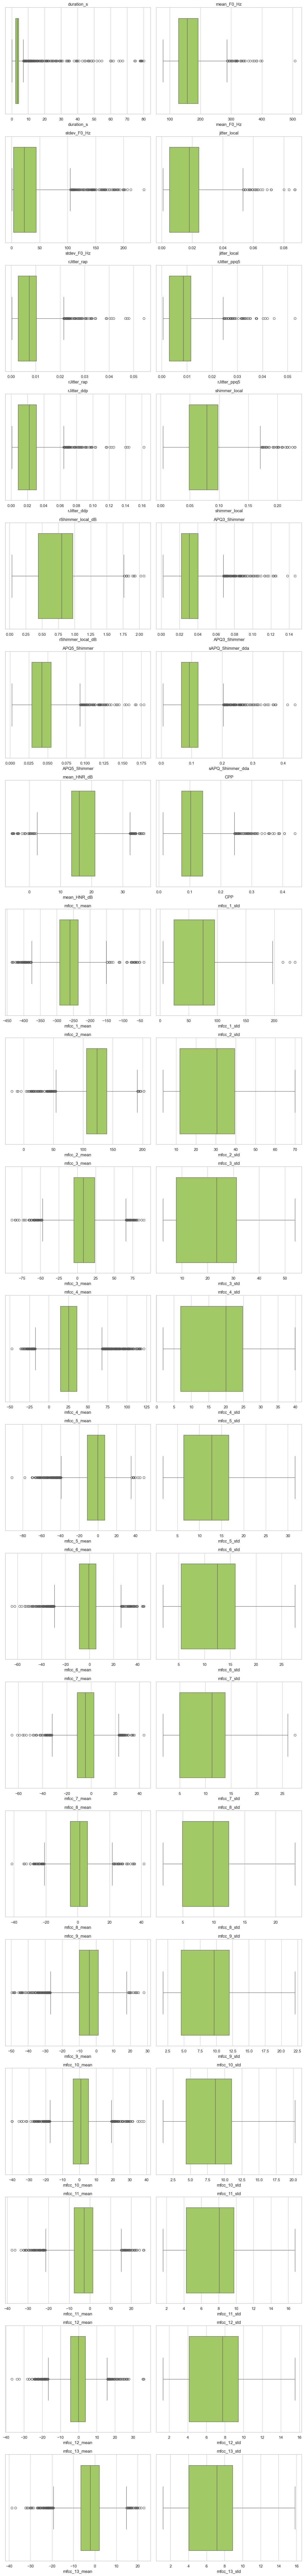

In [155]:
# Columnas numéricas y número de filas necesarias
num_cols = df_features.select_dtypes(include=['float64', 'int64']).columns
n_rows = (len(num_cols) + 1) // 2

plt.figure(figsize=(12, 5 * n_rows))

# Graficar boxplots, 2 por fila
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.boxplot(x=df_features[col], color=palette_set2[4])
    plt.title(col)

plt.tight_layout()
plt.show()

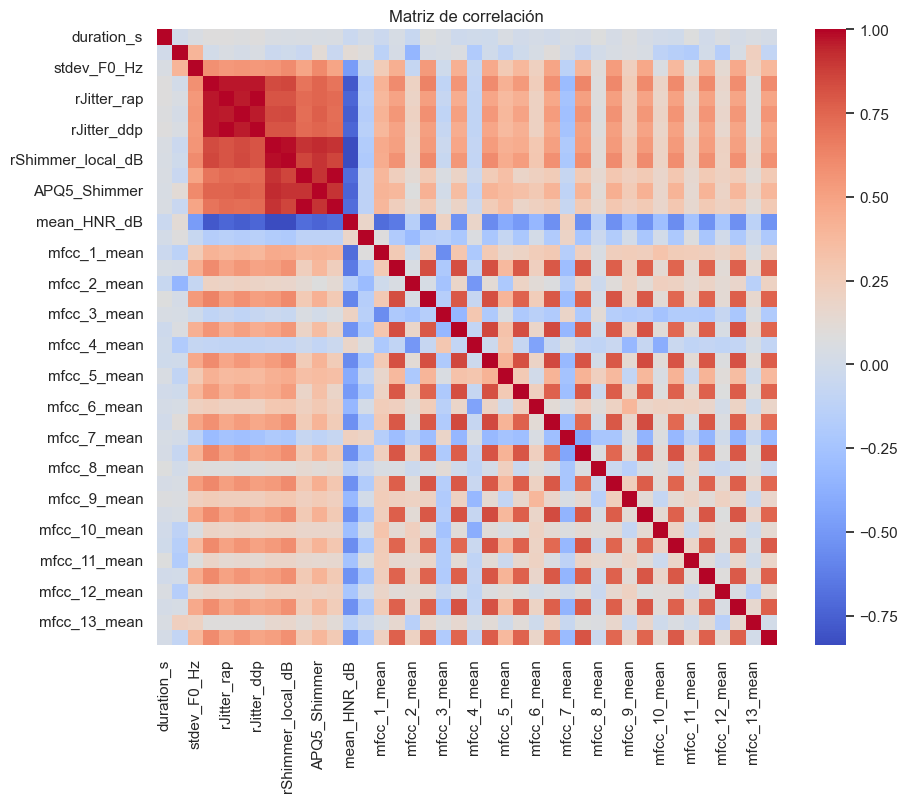

In [156]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr = df_features[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Matriz de correlación")
plt.show()

## Preprocesamiento de Datos (post-EDA)

In [157]:
# Calcular matriz de correlación absoluta entre variables numéricas
corr_matrix = df_features.select_dtypes(include=['number']).corr().abs()

# Crear un dataframe para marcar las correlaciones muy altas (umbral 0.95)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Umbral de correlación
threshold = 0.95

# Encontrar columnas que tienen alguna correlación mayor al umbral
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

# Mostrar variables a eliminar por alta correlación
print(f"Variables a eliminar (correlación > {threshold}): {to_drop}")

# Crear dataframe sin esas variables
df_reduced = df_features.drop(columns=to_drop)

# Opcional: mostrar nueva forma del dataframe
print(f"Dimensiones original: {df_features.shape}, reducido: {df_reduced.shape}")

Variables a eliminar (correlación > 0.95): ['rJitter_rap', 'rJitter_ppq5', 'rJitter_ddp', 'rShimmer_local_dB', 'sAPQ_Shimmer_dda']
Dimensiones original: (2976, 42), reducido: (2976, 37)


In [158]:
# Hacer una copia para no tocar el original
df_model = df_reduced.copy()

# Eliminar columnas irrelevantes para el modelo
df_model = df_model.drop(columns=['AudioPath'])

In [159]:
# Convertir el target a binario
df_model['Group'] = df_model['Group'].map({'HC': 0, 'PD': 1})

## División del conjunto de datos

In [160]:
# Separar X e y
X = df_model.drop(columns=['Group'])
y = df_model['Group']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Modelo de Regresión Logística

### Construcción del modelo

In [161]:
# Pipeline con imputación + escalado + modelo
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [162]:
# Grid de hiperparámetros para búsqueda
param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10, 100],       # valores de C para regularización
    "logreg__penalty": ["l1", "l2"],            # tipo de penalización
    "logreg__solver": ["liblinear"]             # compatible con l1 y l2
}

In [163]:
# GridSearch con validación cruzada (5 folds)
grid_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

In [164]:
# Entrenamiento del modelo
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'logreg__C': [0.01, 0.1, ...], 'logreg__penalty': ['l1', 'l2'], 'logreg__solver': ['liblinear']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [165]:
# Resultados
print("Mejores parámetros:", grid_lr.best_params_)
print("Mejor AUC en CV:", grid_lr.best_score_)

Mejores parámetros: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Mejor AUC en CV: 0.7676064780326521


In [166]:
# Evalúa el mejor modelo con CV para confirmar generalización
best_model_lr = grid_lr.best_estimator_

cv_scores = cross_val_score(best_model_lr, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"AUC CV scores: {cv_scores}")
print(f"Media AUC CV: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

AUC CV scores: [0.77300982 0.79333545 0.75176128 0.75225567 0.76767017]
Media AUC CV: 0.768 ± 0.015


### Evaluación de los modelos

In [167]:
# Predicciones en test
y_pred_lr = grid_lr.predict(X_test)
y_proba_lr = grid_lr.predict_proba(X_test)[:,1]

print("=== Regresión Logística ===")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_lr))

# AUC ROC
auc_roc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"AUC ROC en test: {auc_roc_lr:.3f}")

=== Regresión Logística ===
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       302
           1       0.74      0.70      0.72       294

    accuracy                           0.73       596
   macro avg       0.73      0.73      0.73       596
weighted avg       0.73      0.73      0.73       596

AUC ROC en test: 0.809


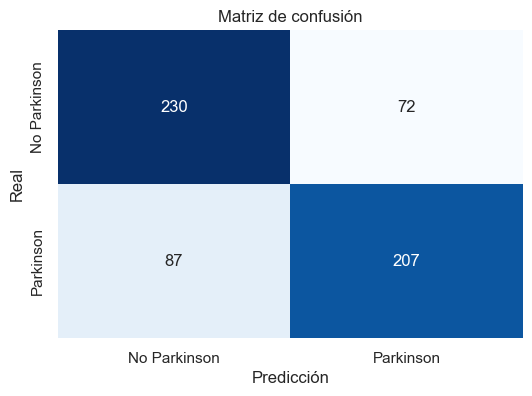

In [168]:
# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

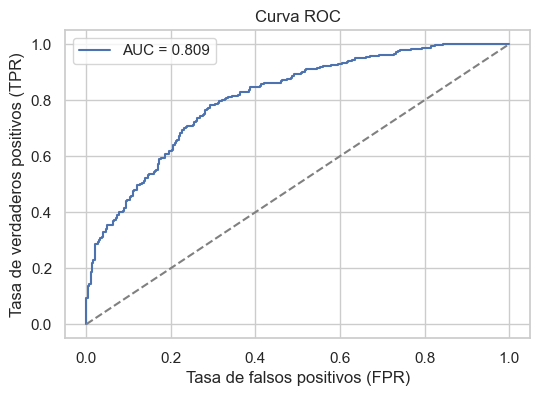

In [169]:
# Calcular FPR, TPR y AUC
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_proba_lr)

# Graficar
plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {auc_roc_lr:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

## Modelo SVM

### Construcción del modelo

In [170]:
# Pipeline SVM
pipeline_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True))                  # Para poder calcular AUC ROC
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [171]:
# Grid de hiperparámetros SVM
param_grid_svm = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}

In [172]:
# GridSearchCV SVM
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring="roc_auc", n_jobs=-1)

In [173]:
# Entrenamiento del modelo
grid_svm.fit(X_train, y_train)

,estimator,Pipeline(step...ility=True))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [174]:
# Resultados
print("Mejores parámetros:", grid_svm.best_params_)
print("Mejor AUC en CV:", grid_svm.best_score_)

Mejores parámetros: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Mejor AUC en CV: 0.9300048309908098


In [175]:
best_model = grid_svm.best_estimator_

In [176]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Obtener probabilidades para la clase positiva
y_proba = best_model.predict_proba(X_test)[:, 1]

# Definir umbrales a probar
thresholds = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Umbral: {thresh:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

Umbral: 0.70 | Precision: 0.94 | Recall: 0.75 | F1: 0.84
Umbral: 0.60 | Precision: 0.91 | Recall: 0.79 | F1: 0.85
Umbral: 0.50 | Precision: 0.87 | Recall: 0.82 | F1: 0.85
Umbral: 0.40 | Precision: 0.86 | Recall: 0.88 | F1: 0.87
Umbral: 0.30 | Precision: 0.83 | Recall: 0.92 | F1: 0.87
Umbral: 0.20 | Precision: 0.77 | Recall: 0.94 | F1: 0.85


### Evaluación de los modelos

In [ ]:
# Predicciones y probabilidades
y_pred_svm = grid_svm.best_estimator_.predict(X_test)
y_proba_svm = grid_svm.best_estimator_.predict_proba(X_test)[:,1]

print("=== SVM ===")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_svm))

# AUC ROC
auc_roc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"AUC ROC en test: {auc_roc_svm:.3f}")

=== SVM ===
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       302
           1       0.89      0.81      0.85       294

    accuracy                           0.86       596
   macro avg       0.86      0.86      0.86       596
weighted avg       0.86      0.86      0.86       596

AUC ROC en test: 0.942


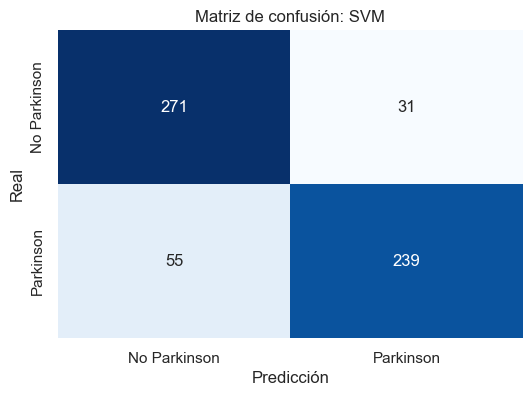

In [178]:
# Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Matriz de confusión (heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión: SVM")
plt.show()

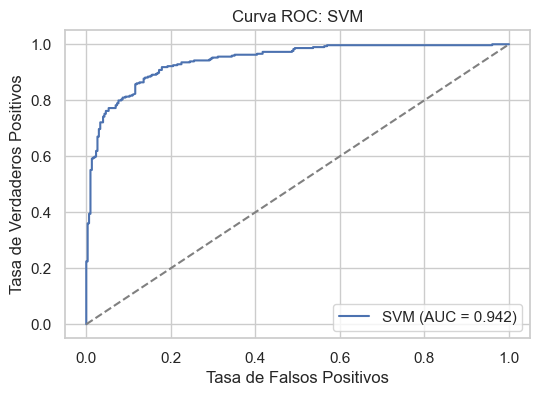

In [ ]:
# Curva ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

plt.figure(figsize=(6,4))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_roc_svm:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC: SVM")
plt.legend()
plt.show()

## Modelo Random Forest

### Construcción del modelo

In [180]:
# Pipeline Random Forest
pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # imputar NaN con media
    ("scaler", StandardScaler()),                   # opcional para RF (se puede quitar si quieres)
    ("rf", RandomForestClassifier(random_state=42))
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [181]:
# Grid de hiperparámetros Random Forest
param_grid_rf = {
    "rf__n_estimators": [100, 200, 500],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None]
}

In [182]:
# GridSearchCV con validación cruzada (5 folds)
grid_rf = GridSearchCV(
    pipeline_rf, param_grid_rf, cv=5,
    scoring="roc_auc", n_jobs=-1, verbose=1
)

In [183]:
# Entrenamiento del modelo Random Forest
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [None, 10, ...], 'rf__max_features': ['sqrt', 'log2', ...], 'rf__min_samples_leaf': [1, 2, ...], 'rf__min_samples_split': [2, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [184]:
# Resultados
print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor AUC en CV:", grid_rf.best_score_)

Mejores parámetros: {'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Mejor AUC en CV: 0.8926006090099126


### Evaluación de los modelos

In [185]:
# Predicciones y probabilidades
y_pred_rf = grid_rf.best_estimator_.predict(X_test)
y_proba_rf = grid_rf.best_estimator_.predict_proba(X_test)[:,1]

# Reporte de clasificación
print("=== Random Forest ===")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_rf))

# AUC ROC
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC ROC en test: {auc_roc_rf:.3f}")

=== Random Forest ===
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       302
           1       0.83      0.83      0.83       294

    accuracy                           0.83       596
   macro avg       0.83      0.83      0.83       596
weighted avg       0.83      0.83      0.83       596

AUC ROC en test: 0.918


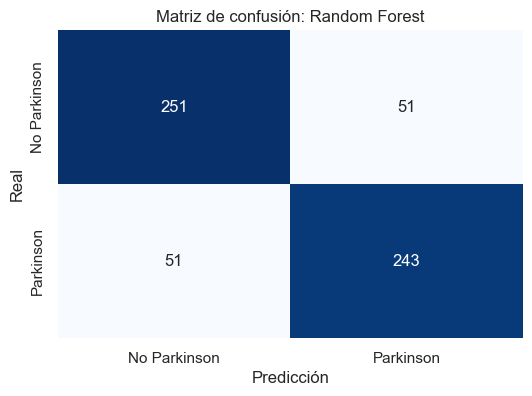

In [186]:
# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Matriz de confusión (heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión: Random Forest")
plt.show()

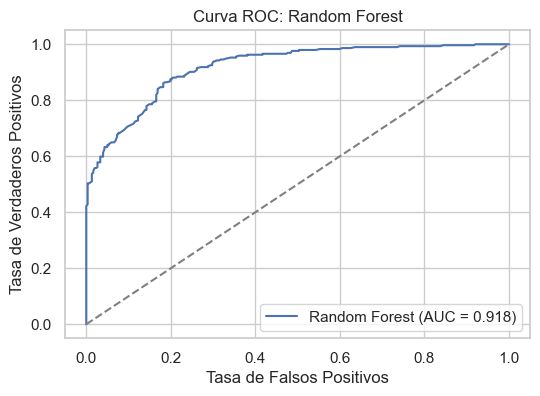

In [187]:
# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_roc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC: Random Forest")
plt.legend()
plt.show()

## Gradient Boosting

### Construcción del modelo

In [188]:
# Pipeline con imputación + escalado + XGBoost
pipeline_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(eval_metric='logloss', random_state=42))
])

### Entrenamiento inicial + ajuste de hiperparámetros con validación cruzada

In [189]:
# Grid de hiperparámetros para XGBoost
param_grid_xgb = {
    "xgb__n_estimators": [100, 200, 500],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__subsample": [0.7, 1.0],
    "xgb__colsample_bytree": [0.7, 1.0],
    "xgb__scale_pos_weight": [1, sum(y_train==0)/sum(y_train==1)]  # Balanceo clases
}

In [190]:
# GridSearchCV con validación cruzada (5 folds) y scoring AUC ROC
grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

In [191]:
# Entrenamiento del modelo
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'xgb__colsample_bytree': [0.7, 1.0], 'xgb__learning_rate': [0.01, 0.1, ...], 'xgb__max_depth': [3, 5, ...], 'xgb__n_estimators': [100, 200, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [192]:
# Resultados
print("Mejores parámetros:", grid_xgb.best_params_)
print("Mejor AUC en CV:", grid_xgb.best_score_)

Mejores parámetros: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 500, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 1.0}
Mejor AUC en CV: 0.9139258038935398


### Evaluación de los modelos

In [193]:
# Predicciones y probabilidades
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)
y_proba_xgb = grid_xgb.best_estimator_.predict_proba(X_test)[:,1]

# Reporte de clasificación
print("=== Gradient Boosting ===")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_xgb))

# AUC ROC
auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC ROC en test: {auc_roc_xgb:.3f}")

=== Gradient Boosting ===
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86       302
           1       0.87      0.82      0.84       294

    accuracy                           0.85       596
   macro avg       0.85      0.85      0.85       596
weighted avg       0.85      0.85      0.85       596

AUC ROC en test: 0.928


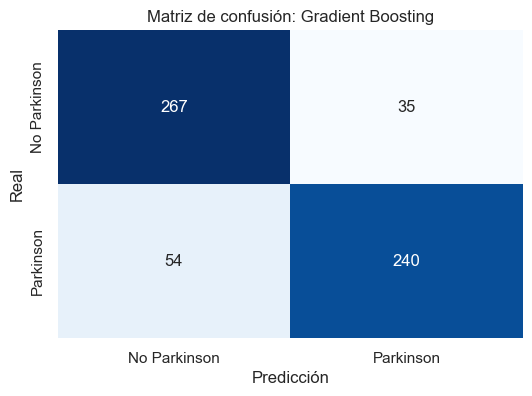

In [194]:
# Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Matriz de confusión (heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Parkinson", "Parkinson"],
            yticklabels=["No Parkinson", "Parkinson"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión: Gradient Boosting")
plt.show()

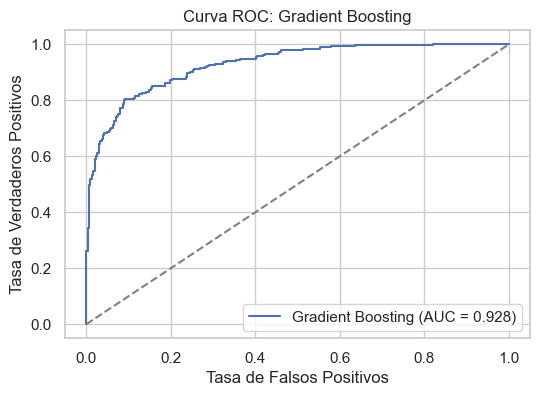

In [195]:
# Curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(6,4))
plt.plot(fpr_xgb, tpr_xgb, label=f"Gradient Boosting (AUC = {auc_roc_xgb:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC: Gradient Boosting")
plt.legend()
plt.show()

In [207]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Preprocesado
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imp)

X_test_imp = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imp)

# Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['AUC'])

# Early stopping (opcional)
early_stop = EarlyStopping(monitor='val_AUC', patience=5, restore_best_weights=True, mode='max')

# Entrenamiento
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluación
y_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_proba >= 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print("=== MLP ===")
print(classification_report(y_test, y_pred))
print(f"AUC ROC en test: {roc_auc_score(y_test, y_proba):.3f}")


Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5501 - loss: 0.6907 - val_AUC: 0.7305 - val_loss: 0.6349
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7130 - loss: 0.6258 - val_AUC: 0.7757 - val_loss: 0.5831
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7721 - loss: 0.5792 - val_AUC: 0.7947 - val_loss: 0.5529
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7683 - loss: 0.5742 - val_AUC: 0.7991 - val_loss: 0.5478
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8085 - loss: 0.5308 - val_AUC: 0.8106 - val_loss: 0.5433
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8143 - loss: 0.5313 - val_AUC: 0.8248 - val_loss: 0.5159
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8504 - loss: 0.4846 - val_AUC: 0.8326 - val_loss: 0.5045
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8576 - loss: 0.4701 - val_AUC: 0.8367 - val_loss: 0.5086
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8353

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# Función que define el modelo con hiperparámetros variables
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    
    # Número de capas ocultas: 1 a 3
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(layers.Dropout(
            rate=hp.Float(f"dropout_{i}", min_value=0.2, max_value=0.5, step=0.1)
        ))
    
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

# Inicializar el tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_AUC',
    max_trials=20,                      # Número de combinaciones a probar
    executions_per_trial=2,             # Para más estabilidad
    directory='keras_tuner_dir',
    project_name='parkinson_mlp_tuning'
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5, mode='max', restore_best_weights=True)

# Lanzar la búsqueda
tuner.search(X_train_scaled, y_train,
             validation_split=0.2,
             epochs=100,
             batch_size=32,
             callbacks=[early_stop],
             verbose=2)

# Mostrar el mejor modelo y los mejores hiperparámetros
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros encontrados:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

# Evaluar el mejor modelo
y_proba = best_model.predict(X_test_scaled).ravel()
y_pred = (y_proba >= 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score
print("=== MLP Tuning ===")
print(classification_report(y_test, y_pred))
print(f"AUC ROC en test: {roc_auc_score(y_test, y_proba):.3f}")

Reloading Tuner from keras_tuner_dir\parkinson_mlp_tuning\tuner0.json
Mejores hiperparámetros encontrados:
num_layers: 2
units_0: 448
dropout_0: 0.4
learning_rate: 0.002454868748703502
units_1: 256
dropout_1: 0.30000000000000004
units_2: 64
dropout_2: 0.2
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
=== MLP Tuning ===
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       302
           1       0.89      0.77      0.82       294

    accuracy                           0.84       596
   macro avg       0.85      0.84      0.84       596
weighted avg       0.85      0.84      0.84       596

AUC ROC en test: 0.918


c:\Users\uroa3\Desktop\Unai\TFM\NeuroVoz_v3_data\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [222]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score

# --- Pipeline de preprocesado ---
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Aplica fit_transform solo en X_train completo (antes de CV)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- Función para crear modelo ---
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 3)):
        units = hp.Int(f"units_{i}", 64, 512, step=64)
        model.add(layers.Dense(units, activation='relu'))
        dropout_rate = hp.Float(f"dropout_{i}", 0.2, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

# --- Cross-validation y búsqueda de hiperparámetros ---

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_val_auc = 0
best_hps = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_processed, y_train), 1):
    print(f"\n--- Fold {fold}/{n_splits} ---")
    X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    tuner = kt.RandomSearch(
        build_model,
        objective='val_AUC',
        max_trials=20,
        executions_per_trial=2,
        directory='keras_tuner_dir',
        project_name=f'parkinson_mlp_tuning_fold_{fold}',
        overwrite=True
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_AUC', patience=5, mode='max', restore_best_weights=True
    )
    
    # TensorBoard callback para cada fold (opcional, pero recomendado)
    tensorboard_cb = keras.callbacks.TensorBoard(log_dir=f'logs/fold_{fold}')

    tuner.search(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop, tensorboard_cb],
        verbose=2
    )

    best_trial_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_trial_auc = tuner.oracle.get_best_trials(num_trials=1)[0].score

    print(f"Best val_AUC in fold {fold}: {best_trial_auc:.4f}")

    if best_trial_auc > best_val_auc:
        best_val_auc = best_trial_auc
        best_hps = best_trial_hps

print("\nMejores hiperparámetros encontrados tras CV:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

# --- Reentrenamiento final con mejor hiperparámetro en todo el train+val ---

final_model = build_model(best_hps)

early_stop_final = keras.callbacks.EarlyStopping(
    monitor='val_AUC', patience=10, mode='max', restore_best_weights=True
)

history = final_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop_final, keras.callbacks.TensorBoard(log_dir='logs/final_model')],
    verbose=2
)

# --- Evaluación en test ---

y_proba = final_model.predict(X_test_processed).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("\n=== Evaluación final en test ===")
print(classification_report(y_test, y_pred))
print(f"AUC ROC en test: {roc_auc_score(y_test, y_proba):.3f}")

Trial 20 Complete [00h 00m 18s]
val_AUC: 0.9094375967979431

Best val_AUC So Far: 0.909764289855957
Total elapsed time: 00h 08m 17s
Best val_AUC in fold 5: 0.9098

Mejores hiperparámetros encontrados tras CV:
num_layers: 2
units_0: 320
dropout_0: 0.2
learning_rate: 0.0009374195595247522
units_1: 384
dropout_1: 0.4
units_2: 320
dropout_2: 0.30000000000000004
Epoch 1/200
60/60 - 1s - 15ms/step - AUC: 0.7123 - loss: 0.6191 - val_AUC: 0.7759 - val_loss: 0.5675
Epoch 2/200
60/60 - 0s - 3ms/step - AUC: 0.8199 - loss: 0.5211 - val_AUC: 0.8262 - val_loss: 0.5090
Epoch 3/200
60/60 - 0s - 3ms/step - AUC: 0.8498 - loss: 0.4825 - val_AUC: 0.8408 - val_loss: 0.4900
Epoch 4/200
60/60 - 0s - 3ms/step - AUC: 0.8696 - loss: 0.4534 - val_AUC: 0.8397 - val_loss: 0.4963
Epoch 5/200
60/60 - 0s - 3ms/step - AUC: 0.8847 - loss: 0.4261 - val_AUC: 0.8566 - val_loss: 0.4696
Epoch 6/200
60/60 - 0s - 3ms/step - AUC: 0.8931 - loss: 0.4122 - val_AUC: 0.8517 - val_loss: 0.4787
Epoch 7/200
60/60 - 0s - 3ms/step - AUC

Resumen comparativo de métricas:
                      Accuracy  Precision    Recall  F1 Score   AUC ROC
Regresión Logística  0.733221   0.741935  0.704082  0.722513  0.808645
SVM                  0.855705   0.885185  0.812925  0.847518  0.942222
Random Forest        0.828859   0.826531  0.826531  0.826531  0.918277
Deep Learning        0.818792   0.854962  0.761905  0.805755  0.910236
Gradient Boosting    0.850671   0.872727  0.816327  0.843585  0.927952


C:\Users\uroa3\AppData\Local\Temp\ipykernel_20292\1006422853.py:31: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.barplot(


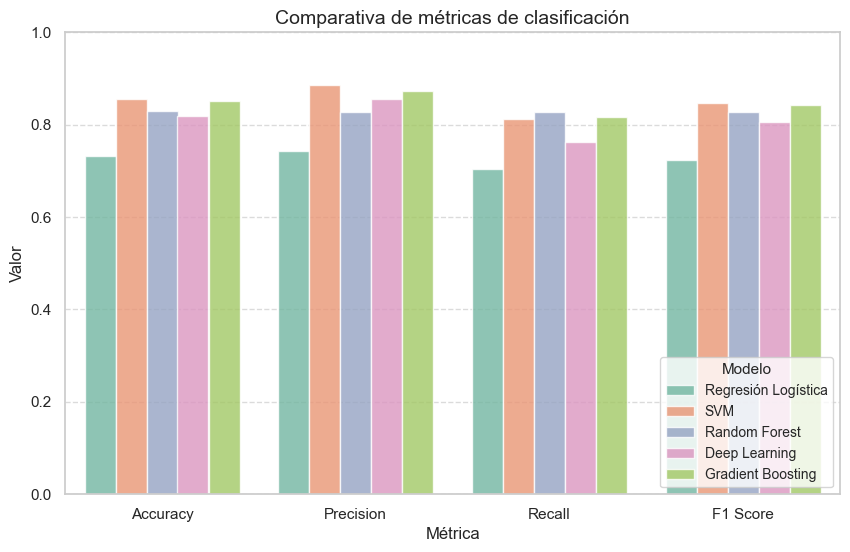

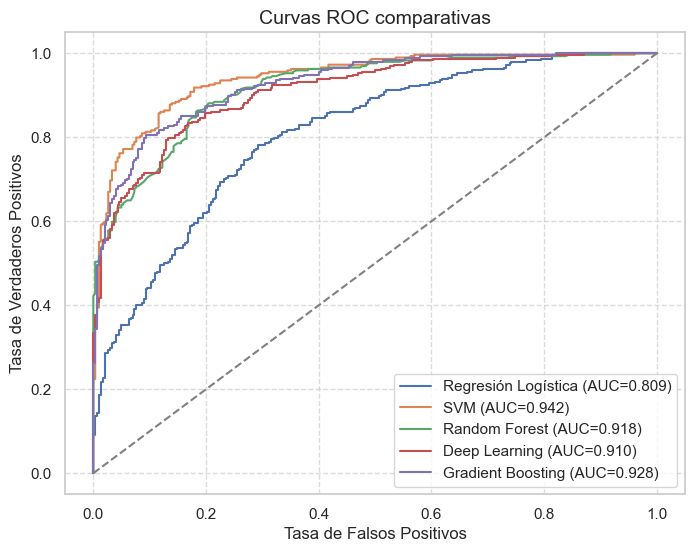

In [227]:
# Lista de modelos
model_names = ['Regresión Logística', 'SVM', 'Random Forest', 'Deep Learning', 'Gradient Boosting']

# Función para calcular métricas clave
def get_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'AUC ROC': roc_auc_score(y_true, y_proba)
    }

# Calcular métricas para cada modelo
metrics_lr = get_metrics(y_test, y_pred_lr, y_proba_lr)
metrics_svm = get_metrics(y_test, y_pred_svm, y_proba_svm)
metrics_rf = get_metrics(y_test, y_pred_rf, y_proba_rf)
metrics_dl = get_metrics(y_test, y_pred, y_proba)
metrics_xgb = get_metrics(y_test, y_pred_xgb, y_proba_xgb)  # Gradient Boosting

# Crear dataframe resumen
metrics_df = pd.DataFrame([metrics_lr, metrics_svm, metrics_rf, metrics_dl, metrics_xgb], index=model_names)
print("Resumen comparativo de métricas:\n", metrics_df)

# Preparar datos para seaborn (formato "long")
metrics_long = metrics_df.reset_index().melt(id_vars='index', var_name='Métrica', value_name='Valor')
metrics_long = metrics_long.rename(columns={'index': 'Modelo'})

# Gráfico de barras con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_long[metrics_long['Métrica'] != 'AUC ROC'],  # Excluimos AUC ROC
    x='Métrica',
    y='Valor',
    hue='Modelo',
    palette=palette_set2,
    alpha=0.8
)
plt.title('Comparativa de métricas de clasificación', fontsize=14)
plt.ylabel('Valor', fontsize=12)
plt.xlabel('Métrica', fontsize=12)
plt.ylim(0, 1)
plt.legend(title='Modelo', fontsize=10, title_fontsize=11, loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Curvas ROC superpuestas para comparación visual
plt.figure(figsize=(8, 6))

# Calcular fpr y tpr para cada modelo
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.plot(fpr_lr, tpr_lr, label=f"Regresión Logística (AUC={metrics_lr['AUC ROC']:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={metrics_svm['AUC ROC']:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={metrics_rf['AUC ROC']:.3f})")
plt.plot(fpr_dl, tpr_dl, label=f"Deep Learning (AUC={metrics_dl['AUC ROC']:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"Gradient Boosting (AUC={metrics_xgb['AUC ROC']:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC comparativas', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()